In [196]:
# Standard libraries
import numpy as np
import json
from datetime import datetime

# Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider

# Own library
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit
#from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
IBM_TOKEN = "56ce0886112e6a0e86ea8eb83e379902e1616cb99deb2ca3505aff78cabeece4757dd9a3e7589dbe9506a643f1876dbf78c2a3444c7a8be123ba413870a11060"

In [126]:
class DeviceParameters(object):
    """Snapshot of the noise of the IBM backend. Can load and save the properties.

    Args:
        qubits_layout (list[int]): Layout of the qubits.

    Attributes:
        qubits_layout (list[int]): Layout of the qubits.
        nr_of_qubits (int): Number of qubits to be used.
        T1 (np.array): T1 time.
        T2 (np.array): T2 time.
        p (np.array): To be added.
        rout (np.array): To be added.
        p_ecr (np.array): Error probabilites in the ECR gate.
        p_ecr (np.array): Gate time to implement controlled not operations in the ECR gate.
        tm (np.array): To be added.
        dt (np.array): To be added.
        
    """

    # Filename when storing the data in text files or a single json file
    f_T1 = "T1.txt"
    f_T2 = "T2.txt"
    f_p = "p.txt"
    f_rout = "rout.txt"
    f_p_ecr = "p_ecr.txt"
    f_t_ecr = "t_ecr.txt"
    f_tm = "tm.txt"
    f_dt = "dt.txt"
    f_json = "device_parameters.json"
    f_metadata = "metadata.json"

    def __init__(self, qubits_layout: list):
        self.qubits_layout = qubits_layout
        self.nr_of_qubits = len(qubits_layout)
        self.T1 = None
        self.T2 = None
        self.p = None
        self.rout = None
        self.p_ecr = None
        self.t_ecr = None
        self.tm = None
        self.dt = None
        self.metadata = None
        self._names = ["T1", "T2", "p", "rout", "p_ecr", "t_ecr", "tm", "dt", "metadata"]
        self._f_txt = ["T1.txt", "T2.txt", "p.txt", "rout.txt", "p_ecr.txt", "t_ecr.txt", "tm.txt", "dt.txt",
                       "metadata.json"]
        
    def is_complete(self) -> bool:
        """ Returns whether all device parameters have been successfully initialized.
        """
        # Check not None
        if any((
                self.T1 is None,
                self.T2 is None,
                self.p is None,
                self.rout is None,
                self.p_cnot is None,
                self.t_cnot is None,
                self.tm is None,
                self.dt is None,
                self.metadata is None)):
            return False

        return True

    def load_from_backend(self, backend):
        """ Load device parameters from the IBM backend. """

        # Load
        prop = backend.properties()
        config = backend.configuration()
        defaults = backend.defaults()

        self.T1 = [prop.t1(j) for j in self.qubits_layout]
        self.T2 = [prop.t2(j) for j in self.qubits_layout]
        self.p = [prop.gate_error('x', [j]) for j in self.qubits_layout]
        self.rout = [prop.readout_error(j) for j in self.qubits_layout]
        self.dt = [backend.configuration().dt]
        self.tm = [prop.readout_length(j) for j in self.qubits_layout]
        self.metadata = {
            "version": datetime.today().strftime('%Y%m%d'),
            "device": config.backend_name,
            "qubits": config.n_qubits,
            "qubits_layout": self.qubits_layout,
            "config": config.to_dict()
        }

        t_ecr = np.zeros((self.nr_of_qubits, self.nr_of_qubits))
        p_ecr = np.zeros((self.nr_of_qubits, self.nr_of_qubits))

        if self.nr_of_qubits > 1:
            for i in range(self.nr_of_qubits):
                if i == 0:
                    t_ecr[0][1] = prop.gate_length('ecr', [self.qubits_layout[1], self.qubits_layout[0]])
                    p_ecr[0][1] = prop.gate_error('ecr', [self.qubits_layout[1], self.qubits_layout[0]])
                if i != 0 and i != self.nr_of_qubits-1:
                    t_ecr[i-1][i] = prop.gate_length('ecr', [self.qubits_layout[i], self.qubits_layout[i-1]])
                    p_ecr[i-1][i] = prop.gate_error('ecr', [self.qubits_layout[i], self.qubits_layout[i-1]])
                    t_ecr[i+1][i] = prop.gate_length('ecr', [self.qubits_layout[i+1], self.qubits_layout[i]])
                    p_ecr[i+1][i] = prop.gate_error('ecr', [self.qubits_layout[i+1], self.qubits_layout[i]])
                if i == self.nr_of_qubits-1:
                    t_ecr[i][i-1] = prop.gate_length('ecr', [self.qubits_layout[i], self.qubits_layout[i-1]])
                    p_ecr[i][i-1] = prop.gate_error('ecr', [self.qubits_layout[i], self.qubits_layout[i-1]])
        self.t_cnot = t_ecr
        self.p_cnot = p_ecr

        # Verify
        if not self.is_complete():
            raise Exception("Loading of device parameters from the backend was not successful: Did not pass verification.")

        return

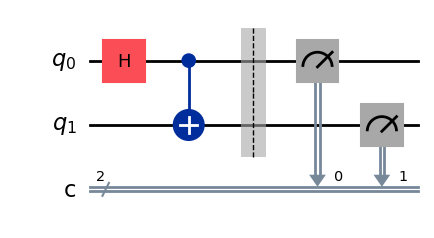

In [105]:
circ = QuantumCircuit(2,2)
circ.h(0)
circ.cx(0,1)
circ.barrier(range(2))
circ.measure(range(2),range(2))
circ.draw('mpl')

In [120]:
config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": "ibmq_manila"
    },
    "run": {
        "shots": 1000,
        "qubits_layout": [0, 1],
        "psi0": [1, 0, 0, 0]
    }
}

In [93]:
#backend_config = config["backend"]
#backend = setup_backend(Token=IBM_TOKEN, **backend_config)


provider = IBMProvider(token=IBM_TOKEN)
backend = provider.get_backend('ibm_brisbane')



prop = backend.properties()



In [121]:
run_config = config["run"]
qubits_layout = run_config["qubits_layout"]
print(qubits_layout)

[0, 1]


In [122]:
prop.gate_length('ecr', [qubits_layout[1], qubits_layout[0]])

6.6e-07

In [130]:

device_param = DeviceParameters(qubits_layout)

device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__




In [176]:
sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)

t_circ = transpile(
    circ,
    backend,
    scheduling_method='asap',
    initial_layout=qubits_layout,
    seed_transpiler=42
)

#t_circ.draw(output='mpl')

In [151]:
raw_data = t_circ.data


In [195]:

raw_data[0][1][0]._index

0

In [198]:

probs = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=2)

counts_ng = {format(i, 'b').zfill(2): probs[i] for i in range(0, 4)}

We only support a linear connectivity at the moment.


AttributeError: 'Qubit' object has no attribute 'index'

In [ ]:
plot_histogram(counts_ng, bar_labels=False, legend=['Noisy Gates simulation'])